## Predicting survival on the Titanic 

The goal is to train a classifier that can predict which passengers `Survived` the Titanic shipwreck based on provided passenger attributes.

In [1]:
import pandas as pd
import numpy as np

In [2]:
train_data = pd.read_csv(r"datasets/titanic/train.csv")
test_data = pd.read_csv(r"datasets/titanic/test.csv")

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# set the PassengerId column as the index column

train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [5]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Get a quick description of the data to see how much info is missing

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


There are `891 instances` in the dataset. The **Age** attribute has `714 non-null` values meaning that
`177` passengers are missing this feature. We can take care of these by replacing the null values with the overall median age.
Another approach involves replacing the null values with the median age of the respective passenger class. 
**Cabin** column has a lot of missing 
features (`only 204 nun-null` are provided). Therefore this column can be ignored entirely during the model training phase.
The **Embarked** column is missing two values which we can probably take care of by replacing with the most common entry in that
column.

In [7]:
# Get descriptive statisctics

train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Only 38% of Titanic passengers survived
- The mean age of the passengers was less than 30 Years old

In [8]:
# confirm that the target values are either 0 0r 1

train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Taking a look at the categorical attributes

In [9]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [10]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [11]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### Build preprocessing pipelines

In [12]:
# pipeline for numerical attributes

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [13]:
num_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [14]:
# pipeline for the categorical attributes

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

cat_pipe = Pipeline([
    ("ordinal_encoder", OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse_output=False))
])

In [15]:
cat_pipe

Pipeline(steps=[('ordinal_encoder', OrdinalEncoder()),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('cat_encoder', OneHotEncoder(sparse_output=False))])

#### Combining the pipelines

In [16]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipe, num_attribs),
        ("cat", cat_pipe, cat_attribs),
    ])

In [17]:
preprocess_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('ordinal_encoder',
                                                  OrdinalEncoder()),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['Pclass', 'Sex', 'Embarked'])])

In [18]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [19]:
y_train = train_data["Survived"]
y_train

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

### Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
# Make predicitions on the test set

X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

In [22]:
y_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [23]:
# Carry out cross-validation
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores

array([0.75555556, 0.79775281, 0.76404494, 0.80898876, 0.88764045,
       0.83146067, 0.83146067, 0.7752809 , 0.84269663, 0.84269663])

In [24]:
forest_scores.mean()

0.8137578027465668

### SVC

In [25]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores

array([0.81111111, 0.85393258, 0.7752809 , 0.87640449, 0.83146067,
       0.79775281, 0.82022472, 0.78651685, 0.85393258, 0.84269663])

In [26]:
svm_scores.mean()

0.8249313358302123

SVC  has a slightly higher mean accuracy compared to the RandomForestClassifier model

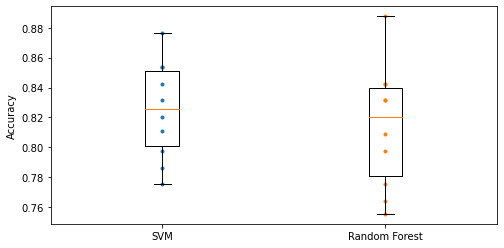

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

The random forest classifier performed exceptionally well in one
of the ten folds, yet its average score was lower and exhibited a wider range, suggesting that the SVM classifier is more likely to generalize well.

### SGD Classifier

In [28]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [29]:
sgd_scores = cross_val_score(sgd_clf, X_train, y_train, cv=10, scoring="accuracy")
sgd_scores

array([0.73333333, 0.78651685, 0.69662921, 0.84269663, 0.78651685,
       0.70786517, 0.83146067, 0.7752809 , 0.84269663, 0.82022472])

In [30]:
sgd_scores.mean()

0.7823220973782771

SGD Classifier is performing poorly as compared to the Random Forest and SVC Classifiers

### KNN Classifier

In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [32]:
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=10)
knn_scores

array([0.77777778, 0.82022472, 0.71910112, 0.79775281, 0.85393258,
       0.80898876, 0.85393258, 0.80898876, 0.83146067, 0.78651685])

In [33]:
knn_scores.mean()

0.8058676654182273

In [34]:
validation_scores = pd.DataFrame({
    'Model': ['Random Forest','SVC','SGD','KNN'],
    'Score': [forest_scores.mean(), svm_scores.mean(), sgd_scores.mean(), knn_scores.mean()]
})
index = [1,2,3,4]
validation_scores.index = index

validation_scores

,Model,Score
1,Random Forest,0.813758
2,SVC,0.824931
3,SGD,0.782322
4,KNN,0.805868


### Fine-tune SVC Model using Grid Search

In [35]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000.]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 6.0, 10,0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

grid_search_SVC = GridSearchCV(svm_clf, param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search_SVC.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] END ..............................C=10.0, kernel=linear; total time=   0.0s
[CV] END ..............................C=10.0, kernel=linear; total time=   0.0s
[CV] END ..............................C=10.0, kernel=linear; total time=   0.0s
[CV] END ..............................C=10.0, kernel=linear; total time=   0.0s
[CV] END ..............................C=10.0, kernel=linear; total time=   0.0s
[CV] END ..............................C=30.0, kernel=linear; total time=   0.1s
[CV] END ..............................C=30.0, kernel=linear; total time=   0.1s
[CV] END ..............................C=30.0, kernel=linear; total time=   0.1s
[CV] END ..............................C=30.0, kernel=linear; total time=   0.0s
[CV] END ..............................C=30.0, kernel=linear; total time=   0.0s
[CV] END .............................C=100.0, kernel=linear; total time=   0.4s
[CV] END .............................C=100.0, 

[CV] END .......................C=6.0, gamma=0.3, kernel=rbf; total time=   0.0s
[CV] END .......................C=6.0, gamma=0.3, kernel=rbf; total time=   0.0s
[CV] END .......................C=6.0, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=6.0, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=6.0, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=6.0, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=6.0, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=6.0, gamma=3.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=6.0, gamma=3.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=6.0, gamma=3.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=6.0, gamma=3.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=6.0, gamma=3.0, kernel=rbf; total time=   0.0s
[CV] END ...................

GridSearchCV(cv=5, estimator=SVC(gamma='auto'),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 6.0, 10, 0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='accuracy', verbose=2)

In [36]:
grid_search_SVC.best_params_

{'C': 3.0, 'gamma': 0.1, 'kernel': 'rbf'}

In [37]:
grid_search_SVC.best_score_

0.8316427091833531

### Fine-tune Random Forest Model using Grid Search

In [38]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 9 (3×3) combinations of hyperparameters
    {'n_estimators': [15, 20, 25], 'max_features': [2, 4, 6]},
    # try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
 
grid_search_forest = GridSearchCV(forest_clf, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True,
                           verbose=2)
grid_search_forest.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ....................max_features=2, n_estimators=15; total time=   0.0s
[CV] END ....................max_features=2, n_estimators=15; total time=   0.0s
[CV] END ....................max_features=2, n_estimators=15; total time=   0.0s
[CV] END ....................max_features=2, n_estimators=15; total time=   0.0s
[CV] END ....................max_features=2, n_estimators=15; total time=   0.0s
[CV] END ....................max_features=2, n_estimators=20; total time=   0.0s
[CV] END ....................max_features=2, n_estimators=20; total time=   0.0s
[CV] END ....................max_features=2, n_estimators=20; total time=   0.0s
[CV] END ....................max_features=2, n_estimators=20; total time=   0.0s
[CV] END ....................max_features=2, n_estimators=20; total time=   0.0s
[CV] END ....................max_features=2, n_estimators=25; total time=   0.0s
[CV] END ....................max_features=2, n_e

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [2, 4, 6],
                          'n_estimators': [15, 20, 25]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='accuracy', verbose=2)

In [39]:
grid_search_forest.best_params_

{'max_features': 4, 'n_estimators': 20}

In [40]:
grid_search_forest.best_score_

0.819327098110602

In [41]:
svc_clf_opt= grid_search_SVC.best_estimator_
svc_clf_opt.fit(X_train, y_train)

SVC(C=3.0, gamma=0.1)

In [42]:
svc_clf_opt_scores = cross_val_score(svc_clf_opt, X_train, y_train, cv=10)
svc_clf_opt_scores

array([0.8       , 0.84269663, 0.76404494, 0.87640449, 0.85393258,
       0.78651685, 0.83146067, 0.7752809 , 0.8988764 , 0.84269663])

In [43]:
svc_clf_opt_scores.mean()

0.8271910112359551

In [44]:
y_pred= svc_clf_opt.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [45]:
preds_df = pd.read_csv(r"datasets/titanic/test.csv")
preds_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [46]:
preds_df["Survived"] = y_pred
preds_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [47]:
final = preds_df.drop(columns=['Name','Pclass','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked'])
final

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [48]:
final["Survived"].value_counts()

0    276
1    142
Name: Survived, dtype: int64

In [49]:
final.to_csv("general_submission.csv", index=False)